Necessary libraries

### Step 1: Importing Necessary Libraries

This cell imports all the Python libraries required for the project. Here's a brief overview of the key ones:

*   **`pandas` (as `pd`):** Used for data manipulation and analysis, particularly for handling our time series data in a structured DataFrame.
*   **`numpy` (as `np`):** Essential for numerical computations, especially for creating and manipulating arrays which form the basis of our model's input and output.
*   **`matplotlib.pyplot` (as `plt`) and `matplotlib.dates` (as `mdates`):** Used for creating static, interactive, and animated visualizations in Python. `mdates` helps in formatting dates on plot axes.
*   **`sklearn.preprocessing.MinMaxScaler`:** A Scikit-learn tool to scale our numerical features (the 'Close' price) to a specific range (typically 0 to 1). This normalization is crucial for the stable training of neural networks like LSTMs.
*   **`tensorflow` (as `tf`):** The core deep learning library we are using.
    *   **`tensorflow.keras.models.Sequential`:** A Keras API for building neural network models layer-by-layer in a linear stack.
    *   **`tensorflow.keras.layers.Dense, LSTM, Dropout`:** Specific types of layers used in our neural network:
        *   `LSTM`: Long Short-Term Memory layers, ideal for sequence data like time series due to their ability to remember information over long periods.
        *   `Dense`: Fully connected neural network layers.
        *   `Dropout`: A regularization technique to prevent overfitting by randomly setting a fraction of input units to 0 at each update during training.
    *   **`tensorflow.keras.callbacks.EarlyStopping`:** A Keras callback to stop training when a monitored metric (like validation loss) has stopped improving, preventing overfitting and saving training time.



In [1]:
!pip install ipympl
!pip install pandas -q
!pip install tensorflow -q

import pandas as pd
from IPython.display import HTML, display
import time
import warnings
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates # Ensure this import is present
from sklearn.preprocessing import MinMaxScaler # Data scaling 0 to 1
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.7/515.7 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.8 MB/s eta 0:00:00


*Seed Initialization (`SEED = 42`, `tf.random.set_seed(SEED)`, `np.random.seed(SEED)`):*
Setting a `SEED` ensures that operations involving randomness (like weight initialization in the neural network, dropout, or even some NumPy operations) produce the same results every time the code is run. This is crucial for **reproducibility** of experiments. The number `42` is a common, arbitrary choice.

In [2]:
SEED = 42

tf.random.set_seed(SEED)

### Step 2: Loading and Correctly Processing Date/Time

In this step, we load our financial time series data. A crucial part is correctly converting the separate `Date` (e.g., integer `20240517`) and `Time` (e.g., string `00:00:00`) columns from the CSV into a single, proper datetime object.

*   **`df = pd.read_csv('EURUSD_5m_1Yea.csv')`**: Reads the raw data.
*   **`df['Timestamp'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'], format='%Y%m%d %H:%M:%S')`**:
    *   `df['Date'].astype(str)`: **This is key.** We first convert the integer `Date` column (e.g., `20240517`) into a string (`"20240517"`).
    *   We then concatenate this string date with the string `Time` column.
    *   `pd.to_datetime(...)` then parses this combined string (e.g., `"20240517 00:00:00"`) using the specified `format='%Y%m%d %H:%M:%S'`.
*   **`df_processed = df[['Timestamp', 'Close']].copy()`**: Creates our working DataFrame with the correct `Timestamp` and `Close` price.
*   **`df_processed.rename(columns={'Timestamp': 'Date'}, inplace=True)`**: Renames for consistency if needed.
*   **Sanity Checks:** After this, printing `df_processed.head()` and `df_processed.dtypes` is essential to confirm the 'Date' column now holds correct datetime objects and not 1970 dates.

In [3]:
# Load the raw CSV data
df_raw = pd.read_csv('EURUSD_5m_1Yea.csv')
print("Raw data head:")
print(df_raw.head())
print("\nRaw data dtypes:")
print(df_raw.dtypes)
print("-" * 30)

# --- CRITICAL DATETIME CONVERSION ---
# Ensure 'Date' is treated as string from the start if it's an integer like 20240517
# and 'Time' is also a string.
try:
    # Combine the original integer 'Date' (as string) and 'Time' columns
    df_raw['Timestamp'] = pd.to_datetime(
        df_raw['Date'].astype(str) + ' ' + df_raw['Time'].astype(str),
        format='%Y%m%d %H:%M:%S',
        errors='raise' # Raise an error if parsing fails
    )
    print("\nSuccessfully created 'Timestamp' column.")
except Exception as e:
    print(f"\nERROR creating 'Timestamp': {e}")
    print("Please check if 'Date' column in CSV is YYYYMMDD integer and 'Time' is HH:MM:SS string.")
    # Fallback or stop execution if critical
    raise e # Stop if conversion fails, as it's fundamental

# Create the working DataFrame with the correct Timestamp and Close price
df_processed = df_raw[['Timestamp', 'Close']].copy()

# Rename 'Timestamp' to 'Date' for consistency with later parts of your notebook, if desired
df_processed.rename(columns={'Timestamp': 'Date'}, inplace=True)

print("\ndf_processed head after datetime conversion:")
print(df_processed.head())
print("\ndf_processed dtypes:")
print(df_processed.dtypes)
print("-" * 30)

# Display the original df for context if needed by later cells (though df_processed is now primary)
# For example, the original notebook showed "Exploitation of the dataset" with "df"
df = df_raw # If 'df' is used later for displaying all original columns

# --- Now, checking for missing data using the correctly processed DataFrame ---
print("\nChecking for missing data in df_processed:")
print(df_processed.isnull().sum())

Raw data head:
       Date      Time     Open     High      Low    Close     Volume
0  20240517  00:00:00  1.08679  1.08688  1.08659  1.08669  397760000
1  20240517  00:05:00  1.08670  1.08670  1.08654  1.08656  154750000
2  20240517  00:10:00  1.08656  1.08656  1.08644  1.08645  335080000
3  20240517  00:15:00  1.08645  1.08645  1.08618  1.08619  626080000
4  20240517  00:20:00  1.08619  1.08628  1.08615  1.08621  364680000

Raw data dtypes:
Date        int64
Time       object
Open      float64
High      float64
Low       float64
Close     float64
Volume      int64
dtype: object
------------------------------

Successfully created 'Timestamp' column.

df_processed head after datetime conversion:
                 Date    Close
0 2024-05-17 00:00:00  1.08669
1 2024-05-17 00:05:00  1.08656
2 2024-05-17 00:10:00  1.08645
3 2024-05-17 00:15:00  1.08619
4 2024-05-17 00:20:00  1.08621

df_processed dtypes:
Date     datetime64[ns]
Close           float64
dtype: object
------------------------

In [21]:
df

,Date,Time,Open,High,Low,Close,Volume,Timestamp
0,20240517,00:00:00,1.08679,1.08688,1.08659,1.08669,397760000,2024-05-17 00:00:00
1,20240517,00:05:00,1.08670,1.08670,1.08654,1.08656,154750000,2024-05-17 00:05:00
2,20240517,00:10:00,1.08656,1.08656,1.08644,1.08645,335080000,2024-05-17 00:10:00
3,20240517,00:15:00,1.08645,1.08645,1.08618,1.08619,626080000,2024-05-17 00:15:00
4,20240517,00:20:00,1.08619,1.08628,1.08615,1.08621,364680000,2024-05-17 00:20:00
...,...,...,...,...,...,...,...,...
74627,20250516,20:35:00,1.11493,1.11493,1.11473,1.11475,152100001,2025-05-16 20:35:00
74628,20250516,20:40:00,1.11475,1.11488,1.11446,1.11482,438530000,2025-05-16 20:40:00
74629,20250516,20:45:00,1.11484,1.11544,1.11480,1.11532,679420000,2025-05-16 20:45:00
74630,20250516,20:50:00,1.11530,1.11618,1.11522,1.11605,971410016,2025-05-16 20:50:00


<Axes: >

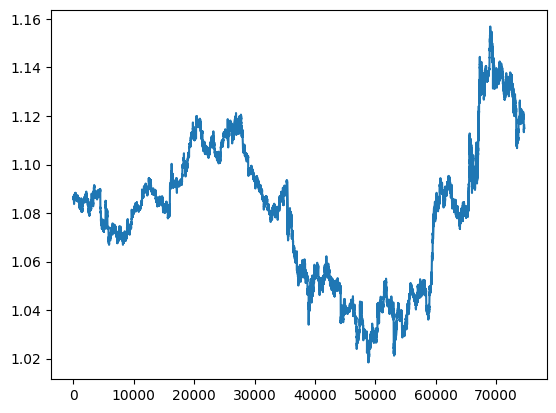

In [4]:
df['Close'].plot()

### Step 3: Splitting Data into Training, Validation, and Test Sets

To evaluate our model's ability to generalize to unseen data, we split the **`df_processed`** dataset (which has correctly formatted dates) into three distinct sets:

1.  **Training Set (`train_df`):** The largest portion of the data, used to train the LSTM model. The model learns patterns and relationships from this data. Here, we use the first 60% of the data.
2.  **Validation Set (`val_df`):** Used to tune hyperparameters and make decisions about the model's architecture during development. It also helps in monitoring for overfitting during training (e.g., with `EarlyStopping`). We use the next 20% of the data after the training set.
3.  **Test Set (`test_df`):** Used for the final, unbiased evaluation of the trained model's performance. This data is kept separate and is *only* used once the model is fully trained and tuned. We use the remaining 20% of the data.

It's crucial for time series data that the split is done chronologically. We train on older data and validate/test on newer data to simulate how the model would be used in a real-world forecasting scenario. We are *not* shuffling the data.

In [5]:
def create_dataset(data, time_steps):
  """
  Pre-organized data for training a Red Neural Recurrent

  prameters:
  data: time-series data
  time_steps: number of time steps for forecasting

  returns:
  dataX: input data
  dataY: output data

  """
  dataX, dataY = [], []
  for i in range(time_steps, len(data)):
    dataX.append(data[i-time_steps:i,0])
    dataY.append(data[i,0])
  return dataX, dataY

In [23]:
if 'df_processed' not in locals() or \
   not (isinstance(df_processed, pd.DataFrame) and \
        'Date' in df_processed.columns and \
        pd.api.types.is_datetime64_any_dtype(df_processed['Date'])): # More robust check
    raise ValueError("ERROR: df_processed is not correctly defined, 'Date' column is missing, or 'Date' column is not datetime. Please re-run Step 2.")

print("Data types in df_processed before splitting:")
print(df_processed.dtypes)
print(f"Shape of df_processed: {df_processed.shape}")
print("-" * 30)

train_size_idx = int(0.6 * len(df_processed))
val_size_idx = train_size_idx + int(0.2 * len(df_processed)) # End index for validation

# Use .copy() to avoid potential SettingWithCopyWarning issues if you modify these slices later
train_df = df_processed.iloc[0:train_size_idx].copy()
val_df = df_processed.iloc[train_size_idx:val_size_idx].copy()
test_df = df_processed.iloc[val_size_idx:].copy()

# Add these lines at the end of your "Step 3" code cell
print("-" * 30)
print("--- Boundary Date Checks ---")

if not train_df.empty:
    print(f"Last date in train_df: {train_df['Date'].iloc[-1]}")
else:
    print("train_df is empty")

if not val_df.empty:
    print(f"First date in val_df: {val_df['Date'].iloc[0]}")
    print(f"Last date in val_df: {val_df['Date'].iloc[-1]}") # <<< THIS IS IMPORTANT
else:
    print("val_df is empty")

if not test_df.empty:
    print(f"First date in test_df: {test_df['Date'].iloc[0]}") # <<< THIS IS IMPORTANT
    print(f"Last date in test_df: {test_df['Date'].iloc[-1]}")
else:
    print("test_df is empty")

if not df_processed.empty:
    print(f"Last date in original df_processed: {df_processed['Date'].iloc[-1]}")
else:
    print("df_processed is empty")

print("-" * 30)

print(f"Training data set size: {len(train_df)}")
print(f"Validation data set size: {len(val_df)}")
print(f"Test data set size: {len(test_df)}")
print("-" * 30)

print("train_df head:")
print(train_df.head())
print("train_df dtypes:")
print(train_df.dtypes) # This should show 'Date' as datetime64[ns]
print("-" * 30)

print("val_df head:")
print(val_df.head())
print("val_df dtypes:")
print(val_df.dtypes) # This should show 'Date' as datetime64[ns]
print("-" * 30)

print("test_df head:")
print(test_df.head())
print("test_df tail")
print(test_df.tail())
print("test_df dtypes:")
print(test_df.dtypes) # This should show 'Date' as datetime64[ns]
print("-" * 30)

Data types in df_processed before splitting:
Date     datetime64[ns]
Close           float64
dtype: object
Shape of df_processed: (74632, 2)
------------------------------
------------------------------
--- Boundary Date Checks ---
Last date in train_df: 2024-12-20 14:20:00
First date in val_df: 2024-12-20 14:25:00
Last date in val_df: 2025-03-06 02:00:00
First date in test_df: 2025-03-06 02:05:00
Last date in test_df: 2025-05-16 20:55:00
Last date in original df_processed: 2025-05-16 20:55:00
------------------------------
Training data set size: 44779
Validation data set size: 14926
Test data set size: 14927
------------------------------
train_df head:
                 Date    Close
0 2024-05-17 00:00:00  1.08669
1 2024-05-17 00:05:00  1.08656
2 2024-05-17 00:10:00  1.08645
3 2024-05-17 00:15:00  1.08619
4 2024-05-17 00:20:00  1.08621
train_df dtypes:
Date     datetime64[ns]
Close           float64
dtype: object
------------------------------
val_df head:
                     Date  

### Step 4: Data Scaling (Normalization)

Neural networks, including LSTMs, generally perform better and train more stably when input features are scaled to a small range. We use `MinMaxScaler` from Scikit-learn to transform our 'Close' prices to a range between 0 and 1.

*   **`scaler = MinMaxScaler(feature_range=(0,1))`**: Initializes the scaler to map values to the [0, 1] range.
*   **`X_train_scaled = scaler.fit_transform(train_df.Close.to_numpy().reshape(-1,1))`**:
    *   `fit_transform()`: The scaler *learns* the minimum and maximum values from the **training data only** (`fit`) and then applies the scaling transformation (`transform`).
    *   It's critical to fit the scaler *only* on the training data to prevent data leakage from the validation or test sets into the training process.
*   **`X_val_scaled = scaler.transform(val_df.Close.to_numpy().reshape(-1,1))`**:
    *   `transform()`: Applies the scaling transformation learned from the training data to the validation set.
*   **`X_test_scaled = scaler.transform(test_df.Close.to_numpy().reshape(-1,1))`**:
    *   `transform()`: Applies the scaling transformation learned from the training data to the test set.
*   **`.to_numpy().reshape(-1,1)`**: Converts the pandas Series of 'Close' prices to a NumPy array and reshapes it into a 2D array (n_samples, 1_feature), which is the expected input format for the scaler.

After prediction, we will use `scaler.inverse_transform()` to convert the scaled predictions back to their original price scale for evaluation and interpretation.

In [7]:
scaler = MinMaxScaler(feature_range=(0,1))
X_train = scaler.fit_transform(train_df.Close.to_numpy().reshape(-1,1))
X_val = scaler.fit_transform(val_df.Close.to_numpy().reshape(-1,1))
X_test = scaler.fit_transform(test_df.Close.to_numpy().reshape(-1,1))

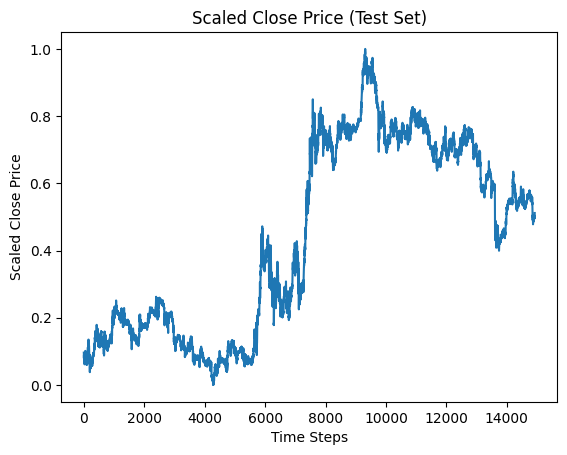

In [8]:
# Plot the X_test data
plt.plot(X_test)
plt.xlabel("Time Steps") # Optional: Add an x-axis label
plt.ylabel("Scaled Close Price") # Optional: Add a y-axis label
plt.title("Scaled Close Price (Test Set)") # Optional: Add a title
plt.show() # Display the plot

### Step 5: Creating Windowed Datasets for LSTM

LSTMs learn from sequences of data. To prepare our time series for an LSTM, we need to create "windows" of data. Each window will consist of a sequence of past observations (features) and a target value to predict.

*   **`WINDOW = 100`**: This defines the **lookback window** or **time steps**. It means the model will use the 'Close' prices from the last 100 time steps (in our case, 100 previous 5-minute intervals) to predict the 'Close' price at the next time step.
    *   Choosing the right `WINDOW` size is a hyperparameter. A larger window provides more historical context but increases computational demand.
*   **`create_dataset(data, time_steps)` function**:
    *   This function iterates through the input `data` (which is one of the scaled price series).
    *   For each point `i` (starting from `time_steps`), it creates:
        *   `dataX`: A sequence (or window) of `time_steps` previous data points: `data[i-time_steps : i, 0]`. This will be an input to the LSTM.
        *   `dataY`: The single data point at time `i`: `data[i, 0]`. This is the target value that the LSTM will try to predict.
    *   The function returns `dataX` (input sequences) and `dataY` (corresponding target values).
*   **`x_train, y_train = create_dataset(X_train_scaled, WINDOW)` (and similarly for val/test sets)**: Applies the windowing function to our scaled training, validation, and test datasets.
    *   `x_train` will have a shape like `(num_samples, WINDOW, 1_feature)`.
    *   `y_train` will have a shape like `(num_samples, 1_target_value)`.

This transformation is fundamental for training sequence models like LSTMs.

In [9]:
WINDOW = 100 # 288 in 5 minutes cycles in a Day

x_train, y_train = create_dataset(X_train, WINDOW)
x_val, y_val = create_dataset(X_val, WINDOW)
x_test, y_test = create_dataset(X_test, WINDOW)

### Step 6: Building the LSTM Model

Here, we define the architecture of our Long Short-Term Memory (LSTM) neural network using the Keras Sequential API.

*   **`model = Sequential()`**: Initializes a linear stack of layers.
*   **`input_shape = (WINDOW, 1)`**: Defines the shape of a single input sample: (`WINDOW` time steps, 1 feature per time step). This is provided to the first LSTM layer.
*   **`model.add(LSTM(50, return_sequences=True, input_shape=input_shape))`**:
    *   Adds the first LSTM layer with **50 units** (or memory cells). The number of units is a hyperparameter that determines the layer's capacity.
    *   `return_sequences=True`: This is important when stacking LSTM layers. It means this layer will output the full sequence of hidden states (one for each time step in the input `WINDOW`) rather than just the hidden state from the final time step. This full sequence is then passed as input to the next LSTM layer.
*   **`model.add(Dropout(0.2))`**:
    *   Adds a Dropout layer with a rate of 0.2. During training, 20% of the input units from the previous layer will be randomly set to zero at each update. This is a regularization technique to help prevent overfitting.
*   **`model.add(LSTM(50))`**:
    *   Adds a second LSTM layer, also with **50 units**.
    *   `return_sequences=False` (default): This layer will only output the hidden state from the *final* time step of its input sequence. This is typical for the last LSTM layer before a Dense output layer in many sequence-to-value prediction tasks.
*   **`model.add(Dropout(0.2))`**: Another Dropout layer for regularization.
*   **`model.add(Dense(1))`**:
    *   Adds a fully connected (Dense) output layer.
    *   It has **1 unit** because we are predicting a single value (the next 'Close' price).
    *   By default, this layer uses a linear activation function, which is suitable for regression tasks like price prediction.

*   **`model.compile(optimizer='adam', loss='mse')`**:
    *   Configures the model for training.
    *   `optimizer='adam'`: Specifies the Adam optimization algorithm, a popular and effective choice for many deep learning tasks.
    *   `loss='mse'`: Sets the loss function to **Mean Squared Error (MSE)**. The model will try to minimize this value during training. MSE is a common loss function for regression problems.
*   **`callbacks = [EarlyStopping(patience=3, restore_best_weights=True)]`**:
    *   Defines a list of callbacks to be used during training.
    *   `EarlyStopping`: This callback will monitor the validation loss (`val_loss`). If the `val_loss` does not improve for a specified number of epochs (`patience=3`), training will be stopped.
    *   `restore_best_weights=True`: If training is stopped by `EarlyStopping`, the model's weights will be reset to those from the epoch with the best (lowest) `val_loss`. This helps prevent using an overfitted version of the model.
*   **`model.summary()` (Implicit, from OCR page 5):** This command prints a summary of the model architecture, including the layers, their output shapes, and the number of trainable parameters. It's very useful for verifying the model structure.

In [10]:
# Define the input shape based on your data (WINDOW time steps, 1 feature)
input_shape = (WINDOW, 1) # Assuming WINDOW is defined earlier in your code

# Build the Sequential model
model = Sequential()

# First LSTM layer with 50 units and the specified input shape
# For stacked LSTMs, all but the last LSTM layer need to return sequences
model.add(LSTM(50, return_sequences=True, input_shape=input_shape))

# First Dropout layer with a rate of 0.2
model.add(Dropout(0.2))

# Second LSTM layer with 50 units
# The last LSTM layer does not need return_sequences=True by default
model.add(LSTM(50))

# Second Dropout layer with a rate of 0.2
model.add(Dropout(0.2))

# Output Dense layer with 1 unit
model.add(Dense(1))

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Compile the model after defining it
model.compile(optimizer='adam', loss='mse') # Example compilation
callbacks = [EarlyStopping(patience=3)]

### Step 7: Reshaping Data for LSTM Input

Keras LSTM layers expect input data in a specific 3D shape: `(samples, time_steps, features)`.

*   **`samples`**: The number of data windows (observations) we have created.
*   **`time_steps`**: The `WINDOW` size, i.e., how many past data points are in each input sequence.
*   **`features`**: The number of input features at each time step. In our current case, we are only using the 'Close' price, so `features = 1`.

*   **`x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)` (and similarly for `x_val`, `x_test`)**:
    *   `x_train.shape[0]` is the number of samples.
    *   `x_train.shape[1]` is the `WINDOW` size (number of time steps).
    *   The `1` explicitly states that we have one feature per time step.
*   **`y_train = np.array(y_train)` (and similarly for `y_val`, `y_test`)**: Ensures the target variables are NumPy arrays, which is generally good practice for TensorFlow/Keras.

This reshaping step ensures our data is in the correct format for the LSTM layers.

In [12]:
# Reshape the data for the LSTM model (samples, time steps, features)

x_train = np.array(x_train).reshape(len(x_train), WINDOW, 1)
x_val = np.array(x_val).reshape(len(x_val), WINDOW, 1)
x_test = np.array(x_test).reshape(len(x_test), WINDOW, 1)

# Convert y_train, y_val, and y_test to NumPy arrays
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)


### Step 8: Training the LSTM Model

This is where the model learns from the training data.

*   **`model.fit(...)`**: This Keras function trains the model.
    *   **`x_train, y_train`**: The input sequences and corresponding target values from our training set.
    *   **`epochs=5`**: The number of times the model will iterate over the entire training dataset. The actual number of epochs run might be less if `EarlyStopping` triggers.
    *   **`batch_size=32`**: The number of training samples processed before the model's weights are updated.
    *   **`validation_data=(x_val, y_val)`**: The data on which to evaluate the loss and any model metrics at the end of each epoch. Using the validation set here allows `EarlyStopping` to monitor performance on unseen data. *Note: The original Colab output showed `validation_data=(x_test, y_test)`, but it's standard practice to use a separate validation set (`x_val, y_val`) for this purpose during training and keep the test set truly held-out for final evaluation.*
    *   **`callbacks=callbacks`**: Passes the `EarlyStopping` callback defined earlier.
    *   **`verbose=1`**: Prints progress updates for each epoch (loss, validation loss, etc.).

During training, you'll observe the `loss` (training loss) and `val_loss` (validation loss) for each epoch. The goal is for both to decrease and for `val_loss` to reach a minimum before it starts to increase (indicating overfitting).

In [13]:
# Model training
model.fit(
    x_train, y_train,
    epochs=5,
    batch_size=32,
    validation_data=(x_test, y_test),
    callbacks=callbacks
    )

Epoch 1/5
1397/1397 ━━━━━━━━━━━━━━━━━━━━ 153s 106ms/step - loss: 0.0068 - val_loss: 3.2860e-04
Epoch 2/5
1397/1397 ━━━━━━━━━━━━━━━━━━━━ 202s 106ms/step - loss: 0.0014 - val_loss: 2.5728e-04
Epoch 3/5
1397/1397 ━━━━━━━━━━━━━━━━━━━━ 202s 106ms/step - loss: 7.2318e-04 - val_loss: 2.1436e-04
Epoch 4/5
1397/1397 ━━━━━━━━━━━━━━━━━━━━ 148s 106ms/step - loss: 4.7705e-04 - val_loss: 2.1693e-04
Epoch 5/5
1397/1397 ━━━━━━━━━━━━━━━━━━━━ 194s 100ms/step - loss: 4.1786e-04 - val_loss: 1.8702e-04


### Step 9: Evaluating the Model

After training (and `EarlyStopping` potentially restoring the best weights), we evaluate the model's performance on the training, validation, and test sets using the primary loss function (MSE in scaled terms).

*   **`model.evaluate(x_train, y_train, verbose=0)`**: Calculates the MSE loss on the training data. `verbose=0` means it won't print progress during evaluation.
*   **`model.evaluate(x_val, y_val, verbose=0)`**: Calculates the MSE loss on the validation data.
*   **`model.evaluate(x_test, y_test, verbose=0)`**: Calculates the MSE loss on the **test data**. This is a key indicator of how well the model generalizes to completely unseen data.

The output of these evaluations will be the Mean Squared Error values for each dataset, based on the *scaled* (0-1 range) data that the model directly processes. Lower values are better. Comparing these helps understand if the model is overfitting (train loss much lower than val/test loss) or underfitting (all losses are high).

In [14]:
print('MSE Train:', model.evaluate(x_train, y_train))
print('MSE Test:', model.evaluate(x_test, y_test))
print('MSE Val:', model.evaluate(x_val, y_val))

1397/1397 ━━━━━━━━━━━━━━━━━━━━ 39s 28ms/step - loss: 4.6439e-05
MSE Train: 7.317894051084295e-05
464/464 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - loss: 2.2863e-04
MSE Test: 0.00018701555381994694
464/464 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - loss: 1.8336e-04
MSE Val: 0.00018226687097921968


### Step 10: Making Predictions and Inverse Scaling

Now that the model is trained, we use it to make predictions on our datasets. Since the model predicts scaled values (between 0 and 1), we then need to inverse-transform these predictions back to the original EURUSD price scale to make them interpretable and comparable to the actual prices.

*   **`pred_train_scaled = model.predict(x_train)`**: Generates predictions for the training set. These are in the scaled (0-1) range.
*   **`pred_val_scaled = model.predict(x_val)`**: Generates predictions for the validation set (scaled).
*   **`pred_test_scaled = model.predict(x_test)`**: Generates predictions for the test set (scaled). This is the most important set for evaluating real-world predictive power.

*   **`scaler.inverse_transform(...)`**: This method uses the `MinMaxScaler` object (`scaler`) that was *fitted on the training data* to convert the scaled predictions (and actual scaled target values) back to their original price magnitude.
    *   **`y_pred_train_orig = scaler.inverse_transform(pred_train_scaled)`**: Inverse-scaled predictions for the training set.
    *   **`y_pred_val_orig = scaler.inverse_transform(pred_val_scaled)`**: Inverse-scaled predictions for the validation set.
    *   **`y_pred_test_orig = scaler.inverse_transform(pred_test_scaled)`**: Inverse-scaled predictions for the test set.
    *   **`y_train_orig = scaler.inverse_transform(y_train.reshape(-1,1))`**: Inverse-scaled *actual* target values for the training set (for comparison).
    *   And similarly for `y_val_orig` and `y_test_orig`.

Having both actual and predicted values in their original price scale allows for meaningful visualization and calculation of error metrics like RMSE and MAE in monetary terms.

In [15]:
# Make predictions on the scaled datasets
pred_train_scaled = model.predict(x_train)
pred_val_scaled = model.predict(x_val)
pred_test_scaled = model.predict(x_test)

# Inverse transform the scaled actual and predicted values to the original scale
y_train_orig = scaler.inverse_transform(y_train.reshape(-1, 1))
y_val_orig = scaler.inverse_transform(y_val.reshape(-1, 1))
y_test_orig = scaler.inverse_transform(y_test.reshape(-1, 1))

y_pred_train_orig = scaler.inverse_transform(pred_train_scaled)
y_pred_val_orig = scaler.inverse_transform(pred_val_scaled)
y_pred_test_orig = scaler.inverse_transform(pred_test_scaled)

1397/1397 ━━━━━━━━━━━━━━━━━━━━ 38s 27ms/step
464/464 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step
464/464 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step


### Step 11: Preparing Dates for Plotting

To plot our predictions against actual values over time, we need the corresponding date/time information for each data point. These dates must be extracted from our `train_df`, `val_df`, and `test_df` DataFrames, which already have the 'Date' column in the correct `datetime64[ns]` format.

*   Recall that `x_train`, `x_val`, and `x_test` (and their corresponding `y` targets) were created using a `WINDOW` of past data. This means the first `WINDOW` data points from each *original scaled series* (derived from `train_df['Close']`, `val_df['Close']`, `test_df['Close']`) do not have a corresponding `y` value (target) or prediction.
*   Therefore, when we select dates from `train_df`, `val_df`, and `test_df`, we need to select the 'Date' values that align with our `y_train_orig`, `y_val_orig`, and `y_test_orig` arrays.
*   **`train_dates = train_df['Date'].iloc[WINDOW:].reset_index(drop=True)`**:
    *   Selects the 'Date' column (which is already `datetime64[ns]`) from `train_df`.
    *   `.iloc[WINDOW:]`: Skips the first `WINDOW` dates. This aligns it with `y_train_orig` because `y_train_orig` starts its predictions *after* the first `WINDOW` period of the training data.
    *   `.reset_index(drop=True)`: Resets the index of the resulting Series for easier plotting.
*   Similar operations are performed for `val_dates` from `val_df`, and `test_dates` from `test_df`.

In [16]:
print("train_df head:")
print(train_df.head())
print("train_df dtypes:")
print(train_df.dtypes) # This should show 'Date' as datetime64[ns]
print("-" * 30)

print("val_df head:")
print(val_df.head())
print("val_df dtypes:")
print(val_df.dtypes) # This should show 'Date' as datetime64[ns]
print("-" * 30)

print("test_df head:")
print(test_df.head())
print("test_df dtypes:")
print(test_df.dtypes) # This should show 'Date' as datetime64[ns]
print("-" * 30)

train_df head:
                 Date    Close
0 2024-05-17 00:00:00  1.08669
1 2024-05-17 00:05:00  1.08656
2 2024-05-17 00:10:00  1.08645
3 2024-05-17 00:15:00  1.08619
4 2024-05-17 00:20:00  1.08621
train_df dtypes:
Date     datetime64[ns]
Close           float64
dtype: object
------------------------------
val_df head:
                     Date    Close
44779 2024-12-20 14:25:00  1.03924
44780 2024-12-20 14:30:00  1.03955
44781 2024-12-20 14:35:00  1.03933
44782 2024-12-20 14:40:00  1.03899
44783 2024-12-20 14:45:00  1.03865
val_df dtypes:
Date     datetime64[ns]
Close           float64
dtype: object
------------------------------
test_df head:
                     Date    Close
59705 2025-03-06 02:05:00  1.08144
59706 2025-03-06 02:10:00  1.08136
59707 2025-03-06 02:15:00  1.08048
59708 2025-03-06 02:20:00  1.08005
59709 2025-03-06 02:25:00  1.08036
test_df dtypes:
Date     datetime64[ns]
Close           float64
dtype: object
------------------------------


In [17]:
# WINDOW should be defined from your "Step 5" (Creating Windowed Datasets)
if 'WINDOW' not in locals():
    WINDOW = 100 # Or whatever your defined WINDOW is, ensure this is correct
    print(f"WARNING: WINDOW not found, defaulting to {WINDOW}. Make sure this is correct.")

# Extract dates from the CORRECT DataFrames (train_df, val_df, test_df)
# These DataFrames already have the 'Date' column as datetime64[ns] from Step 3.
train_dates = train_df['Date'].iloc[WINDOW:].reset_index(drop=True)
val_dates = val_df['Date'].iloc[WINDOW:].reset_index(drop=True)
test_dates = test_df['Date'].iloc[WINDOW:].reset_index(drop=True)

print("--- Verifying extracted dates for plotting ---")
print(f"Length of y_train_orig: {len(y_train_orig) if 'y_train_orig' in locals() else 'y_train_orig not defined'}")
print(f"Length of train_dates: {len(train_dates)}")
print(f"train_dates dtype: {train_dates.dtype}")
if not train_dates.empty: print(f"First 5 train_dates:\n{train_dates.head()}")
print("-" * 30)

print(f"Length of y_val_orig: {len(y_val_orig) if 'y_val_orig' in locals() else 'y_val_orig not defined'}")
print(f"Length of val_dates: {len(val_dates)}")
print(f"val_dates dtype: {val_dates.dtype}")
if not val_dates.empty: print(f"First 5 val_dates:\n{val_dates.head()}")
print("-" * 30)

print(f"Length of y_test_orig: {len(y_test_orig) if 'y_test_orig' in locals() else 'y_test_orig not defined'}")
print(f"Length of test_dates: {len(test_dates)}")
print(f"test_dates dtype: {test_dates.dtype}") # <<< THIS SHOULD NOW BE datetime64[ns]
if not test_dates.empty: print(f"First 5 test_dates:\n{test_dates.head()}") # <<< CHECK THESE VALUES
print("-" * 30)


# Check if lengths match before plotting (lengths of y_..._orig should match respective ..._dates)
if 'y_train_orig' in locals() and len(y_train_orig) != len(train_dates):
    print(f"WARNING: Length of y_train_orig ({len(y_train_orig)}) and train_dates ({len(train_dates)}) do not match!")
if 'y_val_orig' in locals() and len(y_val_orig) != len(val_dates):
    print(f"WARNING: Length of y_val_orig ({len(y_val_orig)}) and val_dates ({len(val_dates)}) do not match!")
if 'y_test_orig' in locals() and len(y_test_orig) != len(test_dates):
    print(f"WARNING: Length of y_test_orig ({len(y_test_orig)}) and test_dates ({len(test_dates)}) do not match!")

--- Verifying extracted dates for plotting ---
Length of y_train_orig: 44679
Length of train_dates: 44679
train_dates dtype: datetime64[ns]
First 5 train_dates:
0   2024-05-17 08:20:00
1   2024-05-17 08:25:00
2   2024-05-17 08:30:00
3   2024-05-17 08:35:00
4   2024-05-17 08:40:00
Name: Date, dtype: datetime64[ns]
------------------------------
Length of y_val_orig: 14826
Length of val_dates: 14826
val_dates dtype: datetime64[ns]
First 5 val_dates:
0   2024-12-22 22:45:00
1   2024-12-22 22:50:00
2   2024-12-22 22:55:00
3   2024-12-22 23:00:00
4   2024-12-22 23:05:00
Name: Date, dtype: datetime64[ns]
------------------------------
Length of y_test_orig: 14827
Length of test_dates: 14827
test_dates dtype: datetime64[ns]
First 5 test_dates:
0   2025-03-06 10:25:00
1   2025-03-06 10:30:00
2   2025-03-06 10:35:00
3   2025-03-06 10:40:00
4   2025-03-06 10:45:00
Name: Date, dtype: datetime64[ns]
------------------------------


### Step 12: Visualizing Predictions

Visualizing the model's predictions against the actual values is crucial for qualitatively assessing its performance. We will generate several independent plots. For plots displaying prices on their original scale, we will use an integer sequence for the x-axis to **collapse time gaps** (e.g., weekends or non-trading periods). This shows a continuous flow of trading activity. Custom date labels will be added to this sequence-based x-axis to provide temporal context, though the spacing between these labels will not be strictly proportional to actual elapsed time.

1.  **Training Set: Actual vs. Predicted (Original Price Scale) - Gaps Collapsed**:
    *   Shows how well the model fits the training data.
    *   The x-axis represents the sequence of trading data points, with selected date/time labels for reference. The y-axis shows EURUSD prices.
    *   This view helps assess if the model learned the patterns in the training data during active periods.

2.  **Validation Set: Actual vs. Predicted (Original Price Scale) - Gaps Collapsed**:
    *   Displays performance on the validation set, which was used for hyperparameter tuning and `EarlyStopping`.
    *   Similar to the training plot, the x-axis is a sequence index with date labels, and the y-axis is the original EURUSD price.
    *   Helps understand how the model generalizes to data it hasn't been directly trained on but has influenced its development.

3.  **Test Set: Actual vs. Predicted (Original Price Scale) - Gaps Collapsed**:
    *   Focuses exclusively on the test set, showing how well the model performs on completely unseen data in its original price context, with non-trading periods visually collapsed.
    *   This is often the most important plot for judging practical utility in terms of price level prediction during active market phases. We look for how closely the predicted line follows the actual price line.

4.  **Test Set: Actual vs. Predicted (Scaled 0-1 Price Scale)**:
    *   Shows the test set comparison but in the 0-1 scaled range that the LSTM model actually operates on.
    *   The x-axis here *is also* a sequence of time steps (integer index), so it naturally has no time gaps.
    *   This helps understand the model's performance at the level of its internal calculations, before inverse scaling.

**Interpreting these "Gap Collapsed" Plots:**

*   **Tracking Price Movements:** Does the predicted line generally follow the direction and magnitude of the actual line during active trading sequences?
*   **Lag:** Is there a noticeable lag in the predictions relative to the sequence of actual prices?
*   **Overfitting/Underfitting:**
    *   If predictions are very good on training but poor on test (even in this gap-collapsed view), it still indicates overfitting to the training sequence.
    *   If predictions are poor on all sets, it might be underfitting or a fundamental issue with the model's ability to capture the sequence dynamics.
*   **Magnitude of Errors:** How far off are the predictions in terms of actual price units during these active sequences?
*   **Behavior during Volatility/Trends:** How does the model perform during periods of high price fluctuation versus stable periods or strong trends within the continuous trading data? The visual "jumps" previously seen due to weekend gaps will now appear as direct transitions between one trading period's end and the next one's start.

This revised plotting approach emphasizes the model's performance on the *sequence of available trading data*, abstracting away the real-world time gaps for these specific visualizations.

Generating independent plots with collapsed gaps...


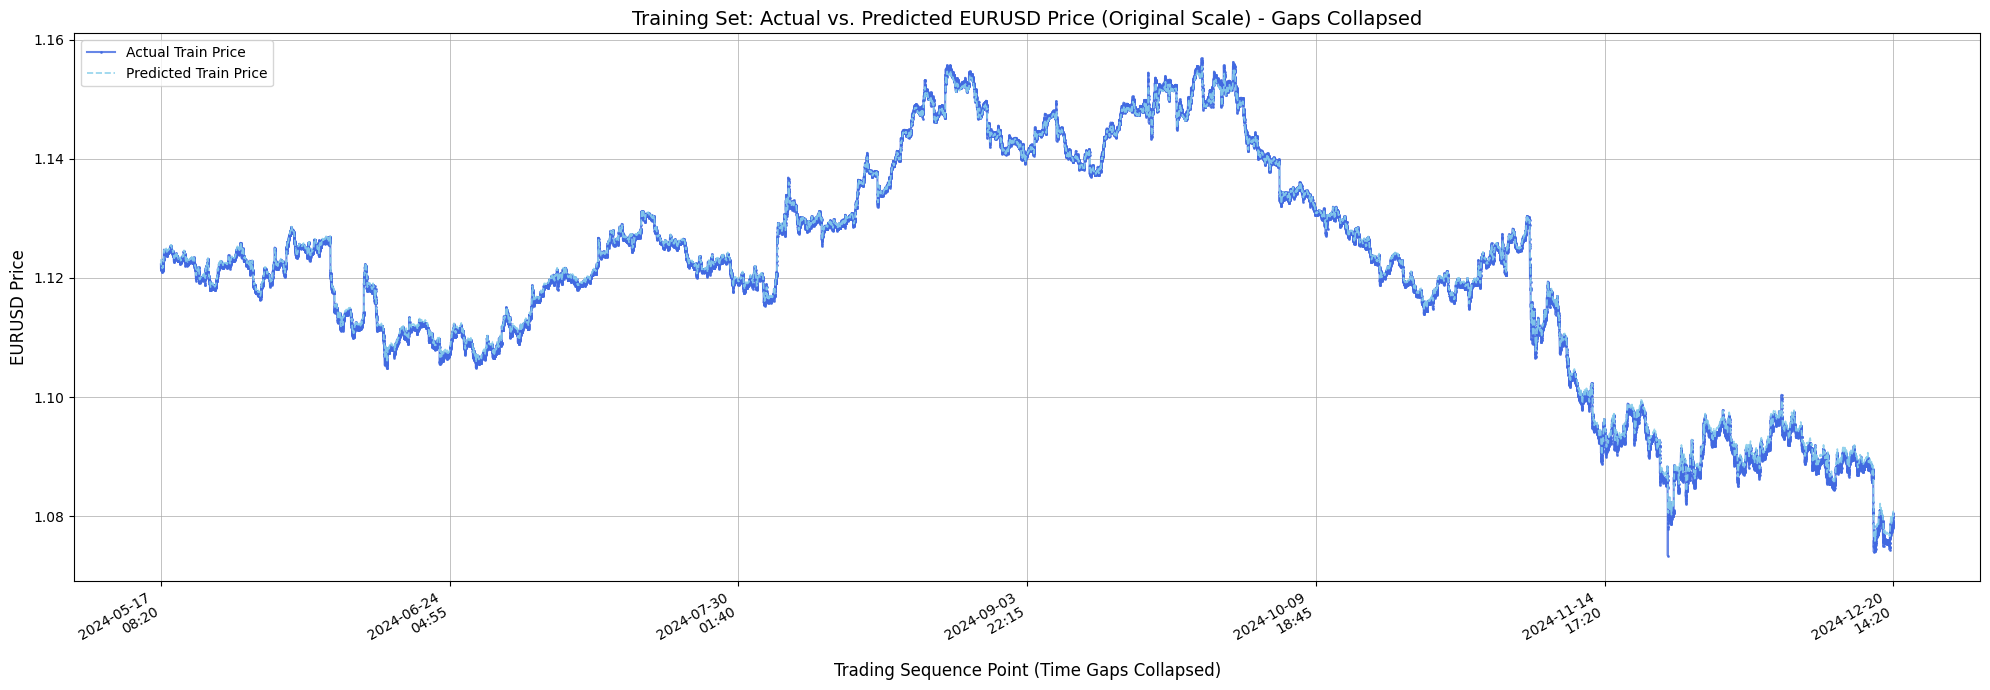

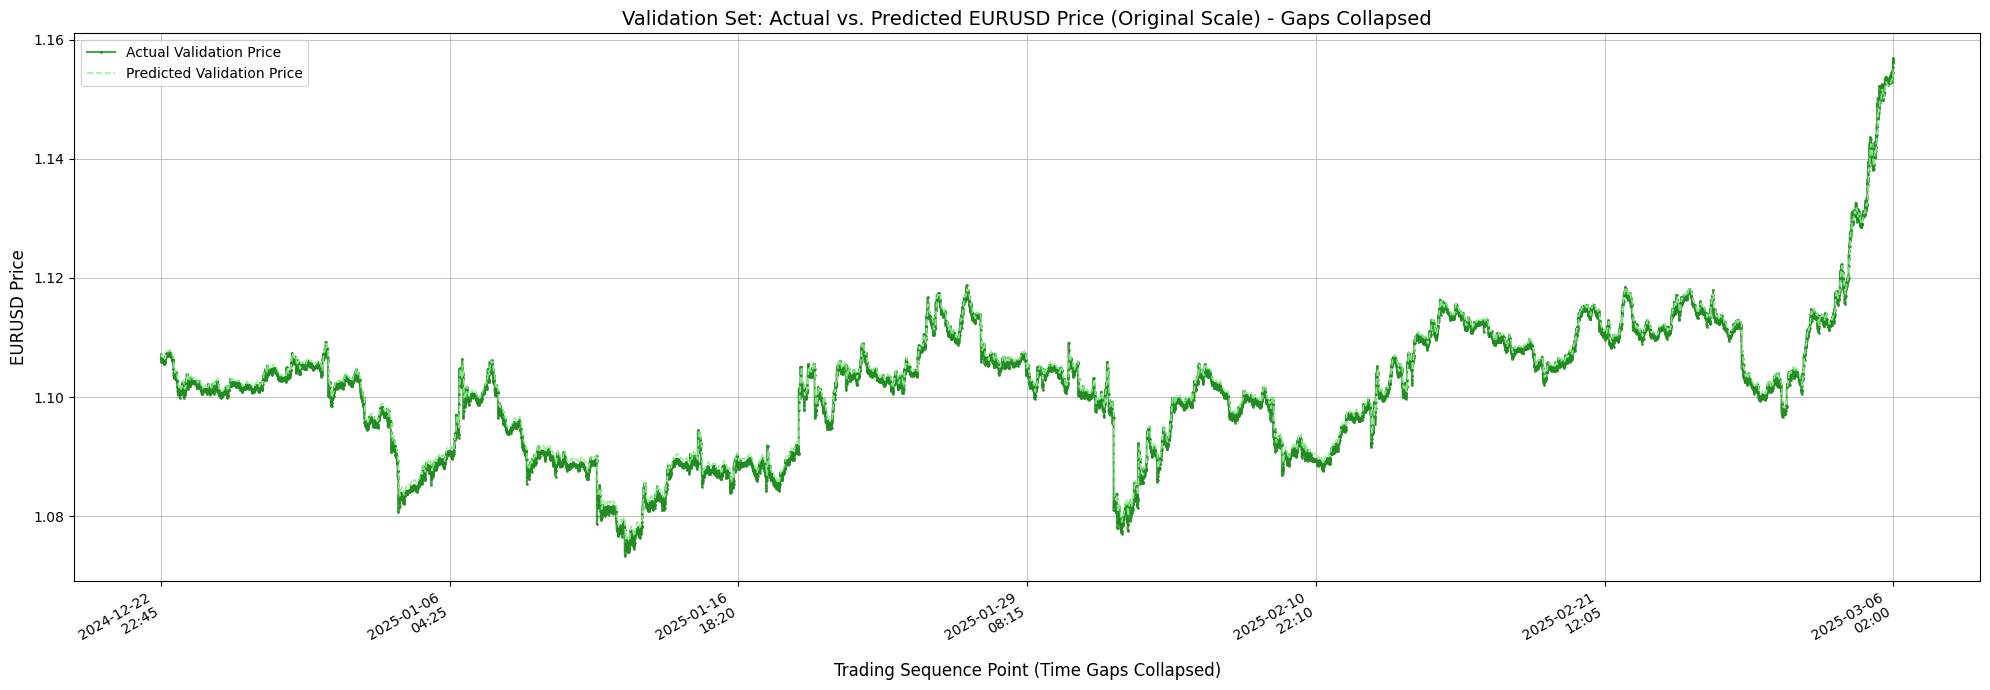

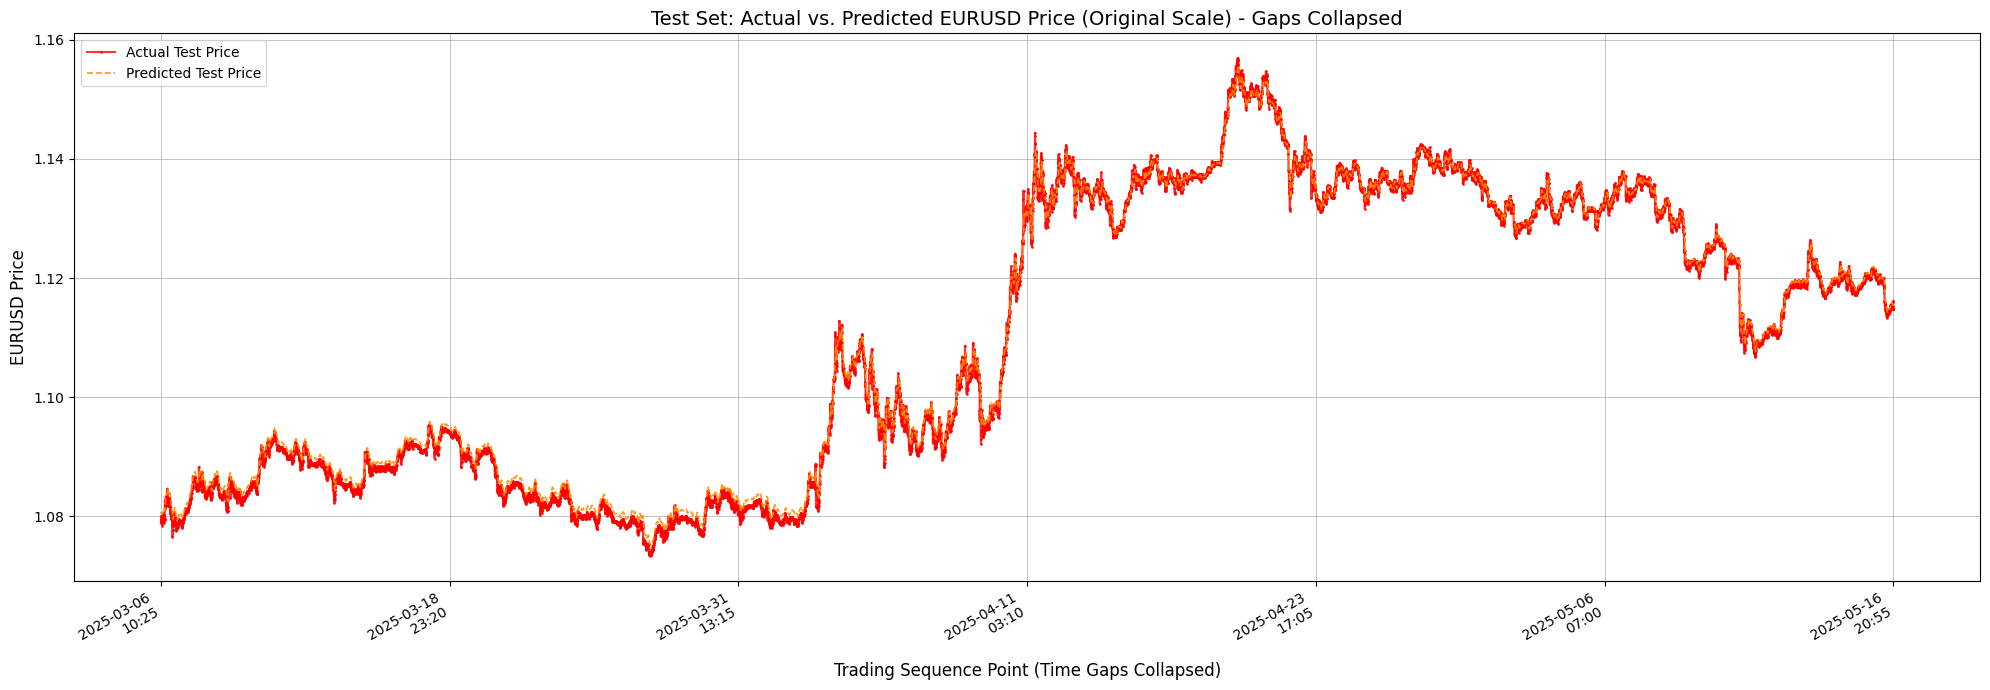

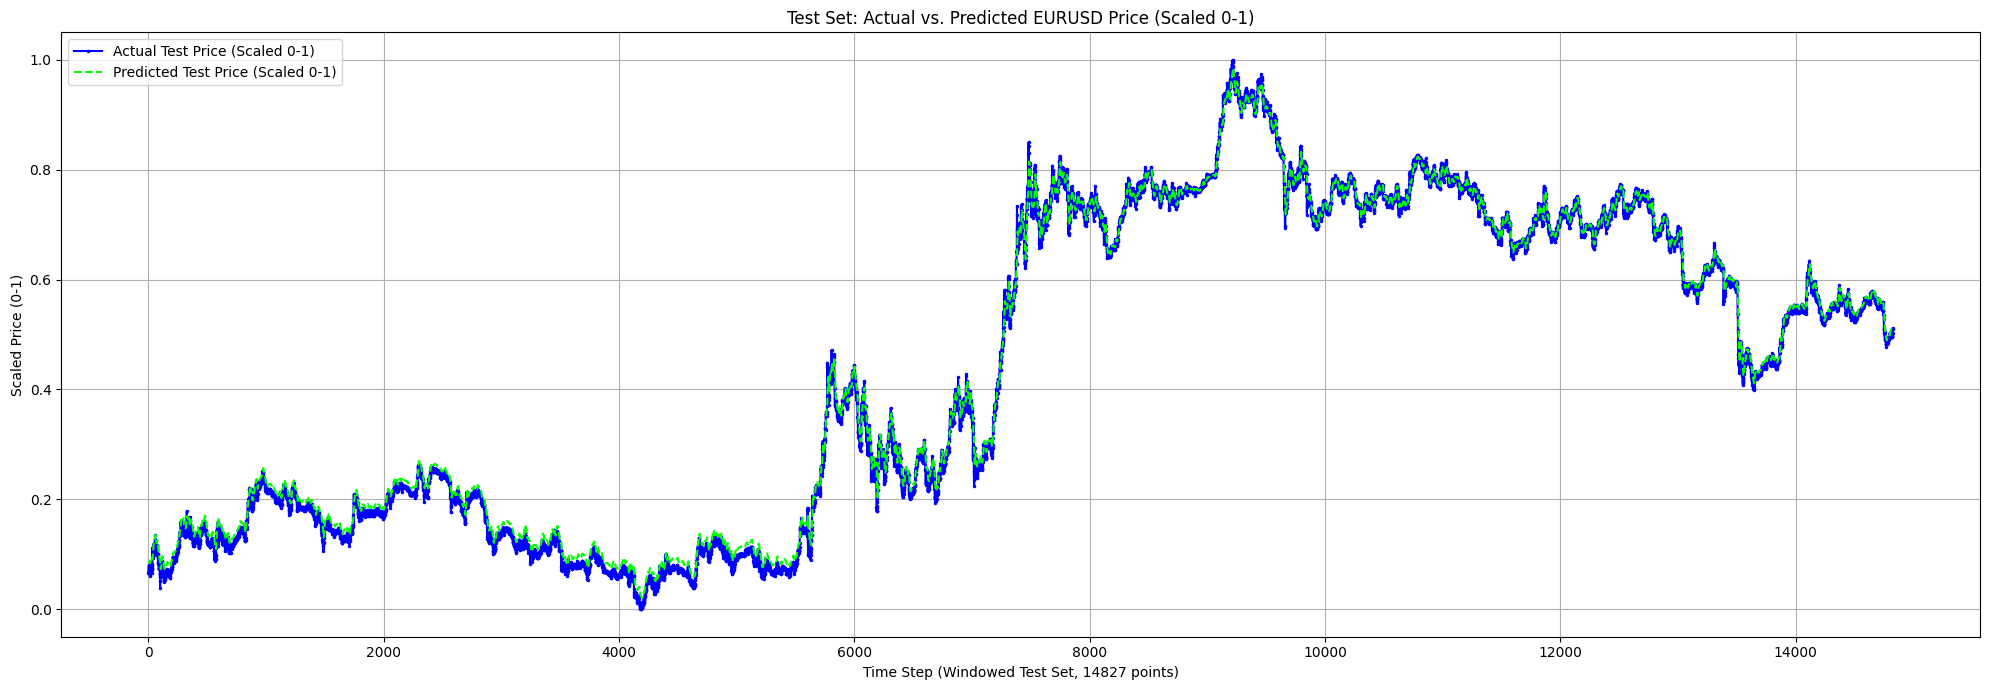

In [24]:
print("Generating independent plots with collapsed gaps...")

# --- Helper function to flatten arrays if they are column vectors ---
def flatten_if_needed(arr):
    if arr is not None and hasattr(arr, 'ndim') and arr.ndim > 1:
        return arr.flatten()
    return arr

# Flatten y arrays (prediction arrays from model.predict() are often 2D)
y_train_orig_flat = flatten_if_needed(locals().get('y_train_orig'))
y_pred_train_orig_flat = flatten_if_needed(locals().get('y_pred_train_orig'))

y_val_orig_flat = flatten_if_needed(locals().get('y_val_orig'))
y_pred_val_orig_flat = flatten_if_needed(locals().get('y_pred_val_orig'))

y_test_orig_flat = flatten_if_needed(locals().get('y_test_orig'))
y_pred_test_orig_flat = flatten_if_needed(locals().get('y_pred_test_orig'))

# --- PLOT FOR TRAINING SET (Gaps Collapsed) ---
if 'train_dates' in locals() and y_train_orig_flat is not None and y_pred_train_orig_flat is not None and \
   len(train_dates) == len(y_train_orig_flat) == len(y_pred_train_orig_flat):

    fig_train, ax_train = plt.subplots(figsize=(20, 7)) # Adjusted height for single plot
    x_axis_index_train = np.arange(len(y_train_orig_flat))

    ax_train.plot(x_axis_index_train, y_train_orig_flat,
                  color='royalblue', linestyle='-', marker='.', markersize=2, alpha=0.8,
                  label='Actual Train Price')
    ax_train.plot(x_axis_index_train, y_pred_train_orig_flat,
                  color='skyblue', linestyle='--', linewidth=1.2, alpha=0.9,
                  label='Predicted Train Price')

    ax_train.set_title('Training Set: Actual vs. Predicted EURUSD Price (Original Scale) - Gaps Collapsed', fontsize=14)
    ax_train.set_xlabel('Trading Sequence Point (Time Gaps Collapsed)', fontsize=12)
    ax_train.set_ylabel('EURUSD Price', fontsize=12)
    ax_train.legend(loc='upper left')
    ax_train.grid(True, which='major', linestyle='-', linewidth='0.5', color='darkgray')

    num_ticks_to_show_train = 7 # Adjust as needed
    tick_indices_train = np.linspace(0, len(x_axis_index_train) - 1, num_ticks_to_show_train, dtype=int)
    # Ensure train_dates has data before trying to access .iloc
    tick_labels_train = [train_dates.iloc[i].strftime('%Y-%m-%d\n%H:%M') if not train_dates.empty and i < len(train_dates) else '' for i in tick_indices_train]
    ax_train.set_xticks(tick_indices_train)
    ax_train.set_xticklabels(tick_labels_train, rotation=30, ha='right')

    plt.tight_layout()
    plt.show()
else:
    print("Skipping Training Set plot due to missing data or length mismatch for train data.")

# --- PLOT FOR VALIDATION SET (Gaps Collapsed) ---
if 'val_dates' in locals() and y_val_orig_flat is not None and y_pred_val_orig_flat is not None and \
   len(val_dates) == len(y_val_orig_flat) == len(y_pred_val_orig_flat):

    fig_val, ax_val = plt.subplots(figsize=(20, 7)) # Adjusted height
    x_axis_index_val = np.arange(len(y_val_orig_flat))

    ax_val.plot(x_axis_index_val, y_val_orig_flat,
                color='forestgreen', linestyle='-', marker='.', markersize=2, alpha=0.8,
                label='Actual Validation Price')
    ax_val.plot(x_axis_index_val, y_pred_val_orig_flat,
                color='lightgreen', linestyle='--', linewidth=1.2, alpha=0.9,
                label='Predicted Validation Price')

    ax_val.set_title('Validation Set: Actual vs. Predicted EURUSD Price (Original Scale) - Gaps Collapsed', fontsize=14)
    ax_val.set_xlabel('Trading Sequence Point (Time Gaps Collapsed)', fontsize=12)
    ax_val.set_ylabel('EURUSD Price', fontsize=12)
    ax_val.legend(loc='upper left')
    ax_val.grid(True, which='major', linestyle='-', linewidth='0.5', color='darkgray')

    num_ticks_to_show_val = 7 # Adjust as needed
    tick_indices_val = np.linspace(0, len(x_axis_index_val) - 1, num_ticks_to_show_val, dtype=int)
    tick_labels_val = [val_dates.iloc[i].strftime('%Y-%m-%d\n%H:%M') if not val_dates.empty and i < len(val_dates) else '' for i in tick_indices_val]
    ax_val.set_xticks(tick_indices_val)
    ax_val.set_xticklabels(tick_labels_val, rotation=30, ha='right')

    plt.tight_layout()
    plt.show()
else:
    print("Skipping Validation Set plot due to missing data or length mismatch for validation data.")

# --- PLOT FOR TEST SET (Gaps Collapsed) ---
# This is the plot you previously confirmed looked good, included here for completeness
if 'test_dates' in locals() and y_test_orig_flat is not None and y_pred_test_orig_flat is not None and \
   len(test_dates) == len(y_test_orig_flat) == len(y_pred_test_orig_flat):

    fig_test, ax_test = plt.subplots(figsize=(20, 7)) # Adjusted height
    x_axis_index_test = np.arange(len(y_test_orig_flat))

    ax_test.plot(x_axis_index_test, y_test_orig_flat,
                 color='red', linestyle='-', marker='.', markersize=2, alpha=0.8,
                 label='Actual Test Price')
    ax_test.plot(x_axis_index_test, y_pred_test_orig_flat,
                 color='darkorange', linestyle='--', linewidth=1.2, alpha=0.9,
                 label='Predicted Test Price')

    ax_test.set_title('Test Set: Actual vs. Predicted EURUSD Price (Original Scale) - Gaps Collapsed', fontsize=14)
    ax_test.set_xlabel('Trading Sequence Point (Time Gaps Collapsed)', fontsize=12)
    ax_test.set_ylabel('EURUSD Price', fontsize=12)
    ax_test.legend(loc='upper left')
    ax_test.grid(True, which='major', linestyle='-', linewidth='0.5', color='darkgray')

    num_ticks_to_show_test = 7 # Adjust as needed
    tick_indices_test = np.linspace(0, len(x_axis_index_test) - 1, num_ticks_to_show_test, dtype=int)
    tick_labels_test = [test_dates.iloc[i].strftime('%Y-%m-%d\n%H:%M') if not test_dates.empty and i < len(test_dates) else '' for i in tick_indices_test]
    ax_test.set_xticks(tick_indices_test)
    ax_test.set_xticklabels(tick_labels_test, rotation=30, ha='right')

    plt.tight_layout()
    plt.show()
else:
    print("Skipping Test Set plot due to missing data or length mismatch for test data.")

# --- (Optional) PLOT 2: Detailed Test Set Comparison (Scaled 0-1 Price Scale) - No Gaps by Design ---
# This plot already uses an integer index and doesn't need modification for gap handling
if 'y_test' in locals() and 'pred_test_scaled' in locals() and \
    len(y_test) == len(flatten_if_needed(pred_test_scaled)):

    fig_scaled, ax_scaled = plt.subplots(figsize=(20, 7)) # Adjusted height
    time_steps_for_plot = np.arange(len(y_test)) # y_test is already defined as the scaled target

    ax_scaled.plot(time_steps_for_plot, y_test, color='blue', marker='.', linestyle='-', markersize=3, label='Actual Test Price (Scaled 0-1)')
    ax_scaled.plot(time_steps_for_plot, flatten_if_needed(pred_test_scaled), color='lime', linestyle='--', linewidth=1.5, label='Predicted Test Price (Scaled 0-1)')

    ax_scaled.set_title('Test Set: Actual vs. Predicted EURUSD Price (Scaled 0-1)')
    ax_scaled.set_xlabel(f'Time Step (Windowed Test Set, {len(y_test)} points)')
    ax_scaled.set_ylabel('Scaled Price (0-1)')
    ax_scaled.legend(loc='upper left')
    ax_scaled.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("Skipping Scaled Test Set plot due to missing data or length mismatch.")

### Step 13: Quantitative Evaluation (Original Price Scale)

While visual inspection is important, quantitative metrics provide objective measures of the model's predictive accuracy on the original price scale.

*   **RMSE (Root Mean Squared Error):**
    *   Calculates the square root of the average of the squared differences between actual and predicted values.
    *   It penalizes larger errors more heavily.
    *   The result is in the same units as the target variable (EURUSD price). Lower is better.
*   **MAE (Mean Absolute Error):**
    *   Calculates the average of the absolute differences between actual and predicted values.
    *   It gives an average magnitude of the error.
    *   The result is also in the same units as the target variable. Lower is better.

We calculate these metrics primarily for the **test set** as it gives the most realistic estimate of the model's performance on new, unseen data.

In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np # Ensure numpy is imported

# Calculate RMSE and MAE for the test set (original price scale)
rmse_test_orig = np.sqrt(mean_squared_error(y_test_orig, y_pred_test_orig))
mae_test_orig = mean_absolute_error(y_test_orig, y_pred_test_orig)

print(f"Test Set RMSE (Original Scale): {rmse_test_orig:.6f} EURUSD") # Format to 6 decimal places
print(f"Test Set MAE (Original Scale): {mae_test_orig:.6f} EURUSD")

# Optionally, calculate for validation and training sets for comparison
if 'y_val_orig' in locals() and 'y_pred_val_orig' in locals(): # Check if validation variables exist
    rmse_val_orig = np.sqrt(mean_squared_error(y_val_orig, y_pred_val_orig))
    mae_val_orig = mean_absolute_error(y_val_orig, y_pred_val_orig)
    print(f"Validation Set RMSE (Original Scale): {rmse_val_orig:.6f} EURUSD")
    print(f"Validation Set MAE (Original Scale): {mae_val_orig:.6f} EURUSD")

if 'y_train_orig' in locals() and 'y_pred_train_orig' in locals(): # Check if training variables exist
    rmse_train_orig = np.sqrt(mean_squared_error(y_train_orig, y_pred_train_orig))
    mae_train_orig = mean_absolute_error(y_train_orig, y_pred_train_orig)
    print(f"Training Set RMSE (Original Scale): {rmse_train_orig:.6f} EURUSD")
    print(f"Training Set MAE (Original Scale): {mae_train_orig:.6f} EURUSD")

# Interpreting these metrics:
# - How do these errors compare to the typical price fluctuations of EURUSD?
# - Is an MAE of, for example, 0.0005 EURUSD acceptable for a potential trading strategy based on 5-minute data?
# - Compare these to a baseline model (e.g., predicting the previous close) to see if the LSTM provides significant improvement.

Test Set RMSE (Original Scale): 0.001141 EURUSD
Test Set MAE (Original Scale): 0.000899 EURUSD
Validation Set RMSE (Original Scale): 0.001127 EURUSD
Validation Set MAE (Original Scale): 0.000884 EURUSD
Training Set RMSE (Original Scale): 0.000714 EURUSD
Training Set MAE (Original Scale): 0.000543 EURUSD
